<a href="https://colab.research.google.com/github/RaimundoLorca/roboticafcfm2021-2/blob/main/Auxiliar_4/Auxiliar_4_Pauta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auxiliar 4: Genetics Algorithms

Los algoritmos genéticos (GA) son una heurística de optimización, inspirada en la evolución biológica, donde los problemas pasan a ser modelados como la simulación de una población de individuos. Durante estas simulaciones, los indiviudos son sometidos a los principios fundamentales de la Teoría de Darwin como la heredabilidad genética, la recombinación genética aleatoria (mutaciones) y la supervivencia de los más aptos (selección natural).

<div align="center"> <img src="https://raw.githubusercontent.com/cherrerab/roboticafcfm/master/auxiliar_04/bin/banner.png" height="220"> </div>

En general, los algoritmos genéticos son convenientes ante problemas que no puedan ser optimizados mediante métodos tradicionales o bien, ante problemas que requieran de simulaciones de una mayor complejidad. No obstante, estos pueden ser implementados para cualquier tipo de problemas con resultados relativamente buenos.

En este taller implementaremos un algoritmo genético utilizando la librería especializada `pyevolve` para resolver el problema de maximización multivariable:

<div align="center">$\max f: f(x,y) = \sin(\frac{3\pi}{10}x)\sin(\frac{3\pi}{10}y)\exp(\frac{-(x-5)^2}{36})$ 

$0 < x,y < 10$</div>



## Pyevolve
`Pyevolve` es una librería de código abierto desarrollada por Christian Perone que funciona como framework para la implementación de algoritmos genéticos. De esta manera, contiene funcionalidades y métodos que permiten diseñar y ejecutar GAs de forma mucho más estructurada, a la vez de mantener una flexibilidad que permite adaptarla a todo tipo de problemas. [Pyevolve documentation](http://pyevolve.sourceforge.net/)

<div align="center"> <img src="https://raw.githubusercontent.com/RaimundoLorca/roboticafcfm2021-2/main/bin/logo_pyevolve.png" height="200"> </div>

Para facilitar su importación en Google Colab, la librería ha sido cargada en el GitHub del curso.

In [12]:
!git clone https://github.com/RaimundoLorca/roboticafcfm2021-2.git
%cd /content/roboticafcfm2021-2

Cloning into 'roboticafcfm2021-2'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (333/333), done.
remote: Total 342 (delta 133), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (342/342), 5.75 MiB | 17.43 MiB/s, done.
Resolving deltas: 100% (133/133), done.
/content/roboticafcfm2021-2


## Genoma

Durante el desarrollo de los algoritmos genéticos, se adoptó una nomenclatura donde cada uno de los conceptos y componentes del problema se corresponden con un término de la teoría de la evolución. En particular, sea $X$ el espacio de búsqueda del problema a optimizar, para modelarlo mediante un GA se debe definir un espacio artificial $S$, tal que existe una función:

<div align="center">$d: S \rightarrow X$

$s \rightarrow d(s) = x$ </div>

Donde entonces, $S$ se conoce como `genotipo` y $X$ como `fenotipo`. Así, un $s$ vendría siendo un representación codificada de un $x$ del problema original, tal como nuestro ADN es una codificación de nuestro cuerpo.

<div align=center> <img src="https://raw.githubusercontent.com/cherrerab/roboticafcfm/master/auxiliar_04/bin/nomlencatura.png" width="500"> </div>

En el caso particular del problema que estamos estudiando, dado que es el espacio de busqueda $X$ es el espacio $\mathbb{R}^2$, el `genotipo` es bastante directo. De este modo, nuestros individuos o `cromosomas` corresponderán a listas de 2 valores `np.float32` entre 0.0 y 10.0. Para esto, `pyevolve` cuenta con el genoma o módulo de representación `pyevolve.G1DList` que configuraremos a continuación.

In [2]:
from pyevolve import G1DList

# Configurar genoma mediante G1DList.G1DList
# esta función recibe la cantidad de elementos del genoma
# http://pyevolve.sourceforge.net/module_g1dlist.html
genome = G1DList.G1DList( size=2 )

# Dado que tanto x como y están acotados entre 0.0 y 10.0
# debemos configurar estos límites mediante G1DList.setParams
genome.setParams(rangemin=0.0, rangemax=10.0)

## Fitness

Sea $f$ la función objetivo que se desea optimizar dentro del espacio de busqueda $X$. Entonces se debe definir una función $\hat{f}$,

<div align="center"> $\hat{f}: S \rightarrow \mathbb{R}$

$\hat{f}(s) \propto f(x)$ </div>

que determina el `fitness` del cromosoma o individuo $s$. Así, la función de `fitness` se encarga de evaluar que tan "bueno" es cada cromosoma en la población y le asigna un valor numérico correspondiente. De este modo, mientras mejor sea un individuo mayor será su fitness. En general, se debe definir la función $\hat{f}$ tal que el `fitness` sea siempre positivo, nunca se indetermine y sea creciente.

Nuevamente, dada la simplicidad del problema que estamos estudiando, es directo que nuestra función de fitness es una evaluación directa de la función que queremos maximizar:

<div align="center"> $f(x,y) = \sin(\frac{3\pi}{10}x)\sin(\frac{3\pi}{10}y)\exp(\frac{-(x-5)^2}{36})$ </div>

In [3]:
import numpy as np

def eval_fitness(chromosome):
  """
	-> float

	La función de fitness se encarga de evaluar que tan bueno es el individuo y
	le asigna el valor numérico correspondiente, mientras mejor sea el individuo,
	mayor será su fitness.
	En este caso, el fitness consiste a la evaluación de la función f(x,y).

	:param list chromosome: lista que contiene los valores x, y del individuo.

	:return: valor de su fitness.
	"""

  # Extraer valores (x, y) de chromosome que sigue la estructura G1DList
  # previamente definida
  x, y = chromosome

  # Calcular fitness f(x, y)
  f = np.sin(x*3*np.pi/10)*np.sin(y*3*np.pi/10)*np.exp(-((x - 5)**2)/36)

  # Sumaremos 5.0 a este valor tal que el fitness sea siempre positivo.
  fitness = f + 5.0

  return fitness

# set función de fitness
genome.evaluator.set( eval_fitness )

## Initilizator

Para comenzar el algoritmo genético y dar paso a esta evolución artificial, es necesario primero contar con una población inicial de individuos. En términos simples, esta población no es más que una lista que contiene los cromosomas $s$ de la primera generación del GA que irán dando paso a las próximas generaciones. No obstante, es importante definir la forma en que esta primera generación será creada, ya sea de manera aleatoria o homogénea, pues esta podría tener una influencia importante en la convergencia del algoritmo y en su resultado.

Para la implementación de este problema no nos complicaremos y simplemente utilizaremos uno de los métodos predifinidos en `pyevolve.Initializators`. En particular, `pyevolve.Initializators.G1DListInitializatorReal` generará la población a partir de valores reales random dentro del rango definido para el genoma. [Initialization methods module](http://pyevolve.sourceforge.net/module_initializators.html)

In [4]:
from pyevolve import Initializators

# Set método de inicialización Initializators.G1DListInitializatorReal
genome.initializator.set( Initializators.G1DListInitializatorReal )

## Crossover

El `Crossover` consiste en el método en que se implementa la heredabilidad genética dentro del algoritmo genético. En este sentido, consiste en un algoritmo que a partir de dos cromosomas ($s_{1}$, $s_{2}$) combina su información genética para crear uno o más nuevos individuos que serán parte de la próxima generación de la población.

Un cruzamiento posible para este problema es que los cromosomas hijos consistan en el promedio de los valores ($x$, $y$) de los padres. No obstante, `pyevolve` cuenta con una serie de métodos de crossover en el módulo `pyevolve.Crossovers`. [Crossover methods module](http://pyevolve.sourceforge.net/module_crossovers.html)

<div align="center"> <img src="https://raw.githubusercontent.com/cherrerab/roboticafcfm/master/auxiliar_04/bin/cruzamiento.png" height="150"> </div>

In [5]:
from pyevolve import Crossovers

def G1DListCrossoverAverage(genome, **kargs):
  """
  -> G1DList, G1DList

  The G1DList Average Crossover
  función de cruzamiento que retorna el promedio de los valores
  de los padres.

  :returns: par de cromosomas producto del cruzamiento
  """
  # Establecer cromosomas padres
  gMom = kargs["mom"]
  gDad = kargs["dad"]

  # Inicializar cromosomas hijos
  sister = gMom.clone()
  brother = gDad.clone()

  sister.resetStats()
  brother.resetStats()

  # Por cada gen del cromosoma
  for i in range( len(gMom) ):

    # Calcular promedio
    sister[i] = (gMom[i] + gDad[i])/2.0
    brother[i] = (gMom[i] + gDad[i])/2.0

  return (sister, brother)

# Set método de cruzamiento
genome.crossover.set( G1DListCrossoverAverage  )

## Mutator

Del mismo modo que el cruzamiento consiste en la adaptación de la heredabilidad genética, el `Mutator` es la implementación de la variabilidad genética en el GA. La importación de la mutación en el GA es que permite la aparición de nuevos genes o cromosomas en la población, lo que a su vez permite recorrer el espacio artifical $S$ sin que la población ni el fitness caiga en una convergencia prematura.

`Pyevolve` también cuenta con el módulo `pyevolve.Mutators` que contiene varios métodos de mutación listos para utilizar. Para este problema utilizaremos el método `pyevolve.Mutators.G1DListMutatorRealRange` para alterar los valores ($x$, $y$) de forma aleatoria dentro del rango numérico definido para el genóma. [Mutation methods module](http://pyevolve.sourceforge.net/module_mutators.html)

In [6]:
from pyevolve import Mutators

# Set método de mutación Mutators.G1DListMutatorRealRange
genome.mutator.set( Mutators.G1DListMutatorRealRange )

## Selector

Ahora damos paso a problamente la etapa más importante dentro de un GA, la selección. Una vez calculado los `fitness` de todos los individuos dentro de la población, del mismo modo que la selección natural en la teoría de Darwin, el algoritmo `Selector` irá seleccionando a los individuos con mayor fitness para generar la siguiente generación. De esta manera, es esta etapa la que posibilita que la optimización ocurra en el GA.

Existen muchas maneras de realizar la selección en un algoritmo genético y las más comunes ya se encuentran implementadas en `pyevolve`. Para este problema utilizaremos la selección por ruleta implementada en `Selectors.GRouletteWheel`. En este método, la probabilidad de que un cromosoma sea seleccionado para cruzamiento es proporcional a su `fitness`, de este modo, aquellos individuos con mayor fitness tendrán más chance de transmitir su información genética a la próxima generación. [Selection methods module](http://pyevolve.sourceforge.net/module_selectors.html)

<div align="center"> <img src="https://raw.githubusercontent.com/cherrerab/roboticafcfm/master/auxiliar_04/bin/seleccion.png" width="400"> </div>

In [7]:
from pyevolve import GSimpleGA
from pyevolve import Selectors

# Comenzaremos por configurar el algoritmo genético
# utilizaremos el Engine GSimpleGA que se encargará de ejecutar
# el proceso evolutivo en cada generación.
# http://pyevolve.sourceforge.net/module_gsimplega.html
GA_RUN = GSimpleGA.GSimpleGA(genome)

# Set método de selección Selectors.GRouletteWheel
GA_RUN.selector.set( Selectors.GRouletteWheel )

## Run GA

Finalmente podemos ejecutar el algoritmo genético para maximizar nuestra función objetivo. Como ya se mencionó, la ejecución es llevada a cabo por el engine `GSimpleGA`, sin embargo, nos falta por configurar la cantidad de individuos en la población, las probabilidades de que ocurra cruzamiento y mutación, y por supuesto, la cantidad de generaciones que durará la ejecución.

In [8]:
# Set tamaño de la población de individuos
GA_RUN.setPopulationSize( 100 )

# Set probabilidades de cruzamiento y mutación
GA_RUN.setCrossoverRate( 0.5 )
GA_RUN.setMutationRate( 0.05 )

# Set cantidad de generaciones a ejecutar
GA_RUN.setGenerations( 200 )

# Ejecutar algoritmo genético
GA_RUN.evolve()

- GenomeBase
	Score:			 5.999999
	Fitness:		 7.097937

	Params:		 {'rangemin': 0.0, 'rangemax': 10.0}

	Slot [Evaluator] (Count: 1)
		Name: eval_fitness - Weight: 0.50
		Doc: 
	-> float

	La función de fitness se encarga de evaluar que tan bueno es el individuo y
	le asigna el valor numérico correspondiente, mientras mejor sea el individuo,
	mayor será su fitness.
	En este caso, el fitness consiste a la evaluación de la función f(x,y).

	:param list chromosome: lista que contiene los valores x, y del individuo.

	:return: valor de su fitness.
	
	Slot [Initializator] (Count: 1)
		Name: G1DListInitializatorReal - Weight: 0.50
		Doc:  Real initialization function of G1DList

    This initializator accepts the *rangemin* and *rangemax* genome parameters.

    
	Slot [Mutator] (Count: 1)
		Name: G1DListMutatorRealRange - Weight: 0.50
		Doc:  Simple real range mutator for G1DList

    Accepts the *rangemin* and *rangemax* genome parameters, both optional.

    
	Slot [Crossover] (Count: 1)
	

Este resultado, nos entrega un resumen del algoritmo genético. En particular, nos entrega la lista del individuo con el mayor `fitness` correspondiente al punto (5.00, 5.00). Podemos extraer este individuo de la población mediante el método `GSimpleGA.bestIndividual()` y luego procesar su información.

In [9]:
# Obtener mejor cromosoma/individuo
bestIndividual = GA_RUN.bestIndividual()

# Podemos acceder a los atributos del cromosoma mediante
# los métodos de la clase G1DList
# http://pyevolve.sourceforge.net/module_g1dlist.html
BEST_FITNESS = bestIndividual.getFitnessScore()
BEST_SCORE = bestIndividual.getRawScore()
BEST_GENOME = bestIndividual.getInternalList()

# Display resultados
print('Generation: {:d}'.format(200))
print('Best genome: ', BEST_GENOME)
print('     score: {:2.3}'.format(BEST_SCORE))
print('     fitness: {:2.3}'.format(BEST_FITNESS))
print('     f(x,y): {:2.3}'.format(BEST_SCORE - 5.0))

Generation: 200
Best genome:  [5.00083374197113, 5.001234746121409]
     score: 6.0
     fitness: 7.1
     f(x,y): 1.0


## Callbacks

A veces podría interesarnos monitorear el avance del GA a medida que este avanza en las generaciones. Por suerte el engine `GSimpleGA` acepta el uso de `Callbacks` en su implementación mediante `GSimpleGA.stepCallback.set`. Los `Callbacks` son funciones o algoritmos que serán ejecutadas al finalizar cada generación. De esta manera, pueden usarse para registrar el progreso del GA, analizar la convergenciá del fitness o bien, como haremos para este para este problema, visualizar la evolución de la población. 

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def Plot3DCallback(GA_ENGINE):
  """
  función de callback que generar un plot 3D de la población en el espacio
  de busqueda determinado por la función f(x,y).
  """
  # obtener generación actual
  # solo se graficará cada 5 generaciones
  if GA_ENGINE.getCurrentGeneration()%5 != 0:
    return None

  # definir límites del espacio cartesiano X, Y
  res = 256
  X = np.linspace(0.0, 10.0, res)
  Y = np.linspace(0.0, 10.0, res)
  Z = np.zeros( (res, res) )

  # para cado punto x, y en el espacio
  for i in range(res):
    for j in range(res):
      # valores x, y
      x, y = X[i], Y[j]

      # evaluar función
      Z[j, i] = np.sin(x*3*np.pi/10)*np.sin(y*3*np.pi/10)*np.exp(-((x - 5)**2)/36)

  # visualizar superficie de la función
  X, Y = np.meshgrid(X, Y)

  fig = plt.figure( figsize=(8,8) )
  ax = fig.gca(projection='3d')

  ax.contour(X, Y, Z, 50, cmap='jet')
  ax.set_xlabel('X'); ax.set_ylabel('Y')

  # ----------------------------------------------------------------------------
  # agregar población al gráfico
  POPULATION = GA_RUN.getPopulation().internalPop
  for indiv in POPULATION:
    chromosome = indiv.getInternalList()
    x, y = chromosome
    z = indiv.getRawScore() - 5.0

    ax.scatter(x, y, z, c='b', s=70)

  return None

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Generation: 35
Best genome:  [4.965827505710061, 4.972793688372123]
     score: 6.0
     fitness: 7.12
     f(x,y): 0.999


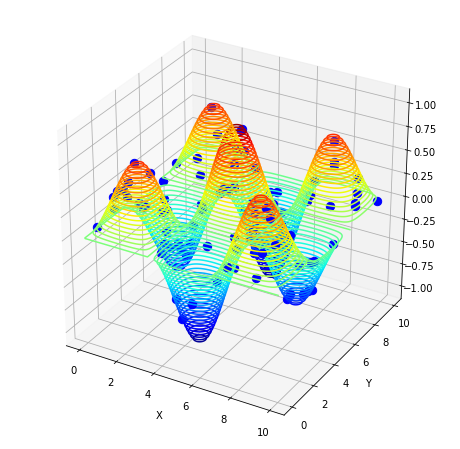

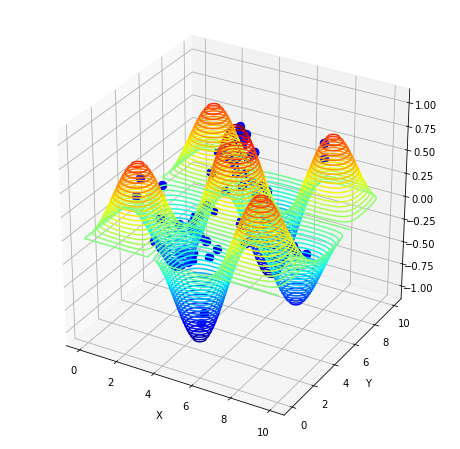

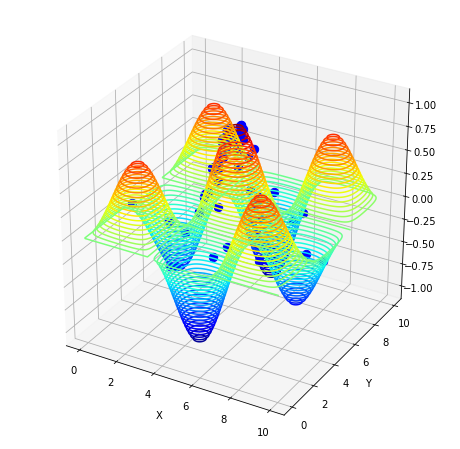

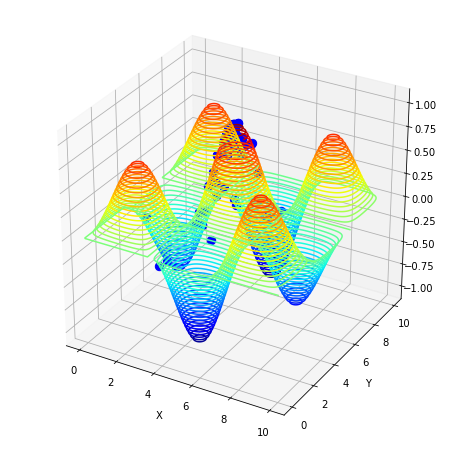

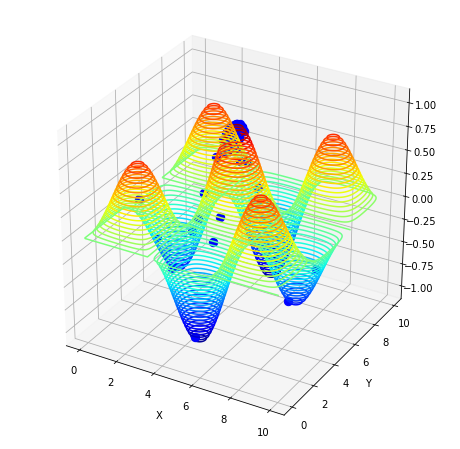

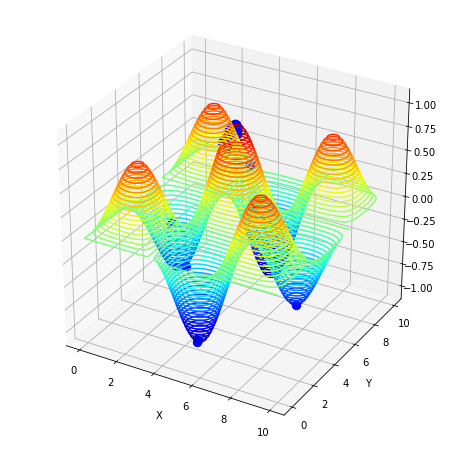

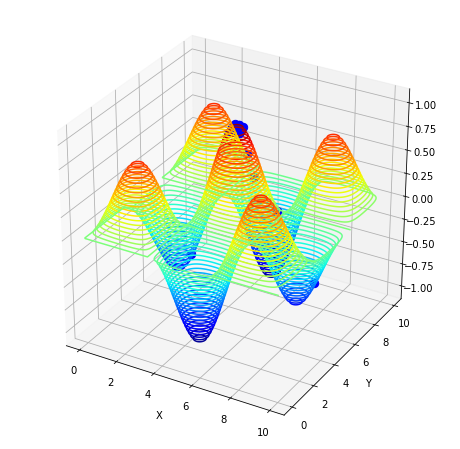

In [17]:
from pyevolve import GSimpleGA
from pyevolve import Selectors

# configurar el algoritmo genético
GA_RUN = GSimpleGA.GSimpleGA(genome)

# set método de selección Selectors.GRouletteWheel
GA_RUN.selector.set( Selectors.GRouletteWheel )

# set tamaño de la población de individuos
GA_RUN.setPopulationSize( 100 )

# set probabilidades de cruzamiento y mutación
GA_RUN.setCrossoverRate( 0.5 )
GA_RUN.setMutationRate( 0.05 )

# set cantidad de generaciones a ejecutar
GA_RUN.setGenerations( 35 )

# set stepCallback
GA_RUN.stepCallback.set( Plot3DCallback )

# ejecutar algoritmo genético
_ = GA_RUN.evolve()

# ---
# obtener mejor cromosoma/individuo
bestIndividual = GA_RUN.bestIndividual()

BEST_FITNESS = bestIndividual.getFitnessScore()
BEST_SCORE = bestIndividual.getRawScore()
BEST_GENOME = bestIndividual.getInternalList()

# display resultados
print('Generation: {:d}'.format(35))
print('Best genome: ', BEST_GENOME)
print('     score: {:2.3}'.format(BEST_SCORE))
print('     fitness: {:2.3}'.format(BEST_FITNESS))
print('     f(x,y): {:2.3}'.format(BEST_SCORE - 5.0))